<img src="./images/gtc_logo.png", class="img-thumbnail" align="left", width=180, height=220>

## <center>"Detection of Anomalies in Financial Transactions using <br/> Deep Autoencoder Networks" </center><br/> 

This GPU Technology Conference (GTC) 2018 lab was developed by XX and YY.
Major parts of the lab contents are derived from the following arXiv submission of the authors: https://arxiv.org/abs/1709.05254.

## 01. Environment Setup and Verification

#### 01.1 Python Verification

Before we begin, let's verify that Python is working on your system. To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Shift-Enter, or pressing the play button in the toolbar above. If all goes well, you should see some output returned below the grey cell.

In [1]:
print('The answer should be forty-two: {}'.format(str(40+2)))

The answer should be forty-two: 42


#### 01.2 Import Python Libraries

In [2]:
# importing utilities
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, display

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

In [3]:
USE_CUDA = True

#### 01.3 CUDNN / GPU Verficiation

In [4]:
# print CUDNN backend version
print('The CUDNN backend version: {}'.format(torch.backends.cudnn.version()))

The CUDNN backend version: None


Let's execute the cell below to display information about the GPUs running on the server.

In [5]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


Let's execute the cell below to display information about the PyTorch version running on the server.

In [6]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] PyTorch version: {}'.format(now, torch.__version__))

[LOG 20180219-06:56:30] PyTorch version: 0.3.0.post4


ToDo:

In [7]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

## 02. Motivation and Lab Overview

### 2.1 The Fraud Challenge and Accounting Information Systems (AIS)

The Association of Certified Fraud Examiners estimates in its Global Fraud Study 2016 [1] that the typical organization loses 5% of its annual revenues due to fraud. 

>The term _"fraud"_ refers, according to Joseph T. Wells [2], to _"the abuse of one's occupation for personal enrichment through the deliberate misuse of an organization's resources or assets"_. 

A similar study, conducted by the auditors of PwC, revealed that nearly a quarter (22%) of respondents experienced losses of between \$100,000 and \$1 million [3]. The study also showed that financial statement fraud caused by far the greatest median loss of the surveyed fraud schemes.

At the same time organizations accelerate the digitization and reconfiguration of business processes [4] affecting in particular Accounting Information Systems (AIS) or more general Enterprise Resource Planning (ERP) systems. Figure 01 depicts a hierarchical view of an Accounting Information System (AIS) recording process and journal entry information in designated database tables.

<img align="middle" style="max-width: 550px; height: auto" src="images/accounting.png">

**Figure 1:** Schematic and hierarchical view of an Accounting Information System (AIS) that records distinct layer of abstractions, namely (1) the business process, (2) the accounting and (3) technical journal entry information in designated database tables.

Steadily, these systems collect vast quantities of electronic evidence at an almost atomic level. This holds in particular for the journal entries of an organization recorded in its general ledger and sub-ledger accounts. SAP, one of the most prominent ERP software providers, estimates that approx. 76% of the world's transaction revenue touches one of their systems [5].

In the context of forensic data analytics the data collected by such systems may contain valuable traces of a potential fraud scheme.

### 2.2 Classification of Financial Anomalies

When conducting a detailed examination of real-world financial transactions, usually recorded in large-scaled AIS ERP systems, two prevalent characteristics can be observed:

> - specific transactions attributes exhibit _a high variety of distinct attribute values_ e.g. customer information, posted subledgers, amount information, and 
> - the transactions exhibit _strong dependencies between certain attribute values_ e.g. between customer informaiton and type of payment, posting type and general ledgers. 

Derived from this observation we distinguish two classes of anomalous financial transactions, namely global and local anomalies as illustrated in Figure 2 below:

<img align="middle" style="max-width: 550px; height: auto" src="images/anomalies.png">

**Figure 2:** Illustrative example of global and local anomalies portrait in a feature space of the two transaction features posting amount (Feature 1) and posting positions (Feature 2).

***Global anomalies***, are financial transactions that exhibit unusual or rare individual attribute values. These anomalies usually relate to highly skewed attributes e.g. seldom posting users, rarely used ledgers, or unusual posting times. Traditionally "red-flag" tests, performed by auditors during annual audits, are designed to capture those types of anomalies. However, such tests might result in a high volume of false positive alerts due to e.g. regular reverse postings, provisions and year-end adjustments usually associated with a low fraud risk.

In [ ]:
# Show sample anomalies

***Local anomalies***, are financial transactions that exhibit an unusual or rare combination of attribute values while the individual attribute values occur quite frequently e.g. unusual accounting records. This type of anomalies is significantly more difficult to detect since perpetrators intend to disguise their activities trying to imitate a regular behavior. As a result, such anomalies usually pose a high fraud risk since they might correspond to e.g. misused user accounts, irregular combinations of general ledger accounts and posting keys that don't follow usual a usual activity pattern.

In [ ]:
# Show sample anomalies

Todo: Add Quiz!

### 2.3 Lab Objective and Prerequisites

The main objective of this lab is to provide you a deep learning (DL) based methodology that can be beneficial to the complex detection of fraudulent activities in financial datasets. The proposed method is based on the following assumptions: 

>- the majority of financial transactions recorded within an organizations’ ERP system relate to regular day-to-day business activities and perpetrators need to deviate from the ”regular” in order to conduct fraud,
>- such deviating behavior will only be recorded by a very limited number of financial transactions and their respective attribute values or attribute combinations and we refer to such deviations as "anomalies".

Based on these assumptions we can learn a model of regular journal entries with minimal ”harm” caused by the potential anomalous ones.

To detect such anomalies we will walk you through a use case of how autoencoder neural networks (AENN), can be trained to learn a compressed but lossy model of regular transactions and their underlying posting pattern. Imposing a strong regularization onto the networks hidden layers limits the networks' ability to memorize the characteristics of anomalous journal entries. Once the training process is completed, the network will be able to reconstruct regular journal entries, while failing to do so for the anomalous ones.

After completing the lab you should be familiar with:

>1. the basic concepts, intuitions and major building blocks of autoencoder neural networks,
>2. the techniques of preprocessing financial data in order to learn a model of its characteristics,
>3. the application of autoencoder neural networks to detect anomalies in large-scale financial data, and,
>4. the interpretation of the detection results of the networks as well as its reconstruction loss. 

Please note, that this lab is not a complete nor comprehensive forensic data analysis approach or fraud examination strategy. However, the methodology and code provided in this lab can be repurposed or adopted to detect anomalous records in a variety of financial datasets. Subsequently, the detected records might serve as a starting point for a more detailed and substantive examination by auditors or compliance personel. 

For this lab we assume that you are familiar with the general concepts of deep neural networks (DNN) and GPUs as well as PyTorch and Python. For more information on these concepts please check the relevant labs of NVIDIA's Deep Learning Institute (DLI). 

## 3. Autoencoder Neural Networks (AENNs)

In this section, we will cover the major building blocks and the specifc network structure of deep autoencoder neural networks (AENNs) as well as an exemplary implementation using the open source machine learning libary PyTorch. The objective of this section is to familiarize with the underlying idea and concepts of building a deep AENN.

### 3.1 Autoencoder Neural Network Architecture

AENNs or replicator neural network are a variant of general feed-forward neural networks that have been initally introduced by xxx. AENNs comprise a symmetrical network architecture with regards to the central hidden layer (referred to as coding layer). The design is chosen intentionally since the training objective of an AENN is to reconstruct its input in a "self-supervised" manner. 

Figure 3 illustrates a schematic view of an AENN.

<img align="middle" style="max-width: 600px; height: auto" src="images/autoencoder.png">

**Figure 3:** Schematic view of an autoencoder network comprised of two non-linear mappings (fully connected feed forward neural networks) referred to as encoder $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ and decoder $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dy}$.

AAEN can be interepreted as "lossy" data compression algorithms. They are "lossy" in a sense that the reconstructed outputs will be degraded compared to the original inputs. The difference between the original input and its reconstruction is referred to as reconstruction error. In general AENN encompass three major building blocks:


>   1. an encoding mapping function $f_\theta$, 
>   2. a decoding mapping function $g_\theta$, 
>   3. and a loss function $\mathcal{L_{\theta}}$.

Most commonly the encoder and the decoder mapping functions are of symmetrical architecture consisting of several layers of neurons followed by a nonlinear function and shared parameters θ. The encoder mapping $f_\theta(\cdot)$ maps an input vector $x^i$ to compressed representation $z^i$ referred to as latent space $Z$. This hidden representation $z^i$ is then mapped back by the decoder $g_\theta(\cdot)$ to a re-constructed vector $x^i$ of the original input space. Formally, the nonlinear mappings of the encoder and the decoder can be defined by:

<center>$f_\theta(x^i) = s(Wx^i + b)$, and $g_\theta(z^i) = s′(W′z^i + d)$,</center>

where $s$ and $s′$ denote a non-linear activations with model parameters $\theta = \{W, b, W', d\}$, $W \in \mathbb{R}^{d_x \times d_z}, W' \in \mathbb{R}^{d_z \times d_y}$ are weight matrices and $b \in \mathbb{R}^{dx}$, $d \in \mathbb{R}^{dz}$ are the offset bias vectors.

### 3.3 Autoencoder Neural Network Implementation

Now, let's start the AENN implementation by first implementing the encoder network using PyTorch. For the encoder network model we aim to implement a model consisting of six fully-connected layers. The model is specified by the following number of neurons per layer: "128-64-32-16-8-3". Meaning the first layer consists of 128 neurons, the second layer of 64 neurons and the subsequent layers of 32, 16, 8 and 3 neurons respectively.

Some elements of the code should be given particular attention:

>- `self.encoder_Lx`: defines the linear transformation of the layer applied to the incoming data: $Wx + b$.
>- `nn.init.xavier_uniform`: inits the layer weights using a uniform distribution according to [6]. 
>- `self.encoder_Rx`: defines the non-linear transformation of the layer: $\sigma(\cdot)$.
>- `self.dropout`: randomly zeroes some of the elements of the input tensor with probability $p$ according to [9].

We use Leaky ReLUs as introduced by Xu et al. in [7] to avoid "dying ReLUs" and to speed up training convergence. Leaky ReLUs allow a small gradient even when a particular neuron is not active. Finally, we set the probability to $p=0.2$ (20%) for each neuron to be set to zero at a forward pass to prevent the network from overfitting.

In [8]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 186, out 128
        self.encoder_L1 = nn.Linear(in_features=186, out_features=128, bias=True) # add linearity 
        nn.init.xavier_uniform(self.encoder_L1.weight) # init weights according to [6]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [todo]

        # specify layer 2 - in 128, out 64
        self.encoder_L2 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 64, out 32
        self.encoder_L3 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 32, out 16
        self.encoder_L4 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 16, out 8
        self.encoder_L5 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 3
        self.encoder_L6 = nn.Linear(8, 3, bias=True)
        nn.init.xavier_uniform(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.encoder_L6(x)) # don't apply dropout to the AE bottleneck

        return x

Now, we are now ready to intstantiate the encoder model for CPU tensors or using CUDNN for CUDA tensor types (to utilize potential available GPUs for computation).

In [9]:
# init training network classes / architectures
encoder_train = encoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder().cuda()

Once the model is initialized you can pre-visualize the model structure and review the implemented network architecture.

In [10]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20180219-06:56:38] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=186, out_features=128)
  (encoder_R1): LeakyReLU(0.4, inplace)
  (encoder_L2): Linear(in_features=128, out_features=64)
  (encoder_R2): LeakyReLU(0.4, inplace)
  (encoder_L3): Linear(in_features=64, out_features=32)
  (encoder_R3): LeakyReLU(0.4, inplace)
  (encoder_L4): Linear(in_features=32, out_features=16)
  (encoder_R4): LeakyReLU(0.4, inplace)
  (encoder_L5): Linear(in_features=16, out_features=8)
  (encoder_R5): LeakyReLU(0.4, inplace)
  (encoder_L6): Linear(in_features=8, out_features=3)
  (encoder_R6): LeakyReLU(0.4, inplace)
  (dropout): Dropout(p=0.0, inplace)
)



As as next step let's complete the AENN implementation by implementing the decoder model. The design of the decoder model architecture also consists of six fully-connected layers. The decoder model is intended to mirror the encoder architecture by a layerwise inversion "8-16-32-64-128-186" of the encoder layers.

In [11]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 8
        self.decoder_L1 = nn.Linear(in_features=3, out_features=8, bias=True) # add linearity 
        nn.init.xavier_uniform(self.decoder_L1.weight)  # init weights according to [todo]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [todo]

        # specify layer 1 - in 8, out 16
        self.decoder_L2 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 16, out 32
        self.decoder_L3 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 32, out 64
        self.decoder_L4 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 64, out 128
        self.decoder_L5 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 128, out 186
        self.decoder_L6 = nn.Linear(128, 186, bias=True)
        nn.init.xavier_uniform(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.decoder_L6(x)) # don't apply dropout to the AE output
        
        return x

Let's also intstantiate the encoder model for CPU tensors or using CUDNN for CUDA tensor types (to utilize potential available GPUs for computation) and convince ourselves that it was successfully initialized by printing and reviewing the initialized architecture.

In [12]:
# init training network classes / architectures
decoder_train = decoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None):
    decoder_train = decoder().cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20180219-06:56:40] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=8)
  (decoder_R1): LeakyReLU(0.4, inplace)
  (decoder_L2): Linear(in_features=8, out_features=16)
  (decoder_R2): LeakyReLU(0.4, inplace)
  (decoder_L3): Linear(in_features=16, out_features=32)
  (decoder_R3): LeakyReLU(0.4, inplace)
  (decoder_L4): Linear(in_features=32, out_features=64)
  (decoder_R4): LeakyReLU(0.4, inplace)
  (decoder_L5): Linear(in_features=64, out_features=128)
  (decoder_R5): LeakyReLU(0.4, inplace)
  (decoder_L6): Linear(in_features=128, out_features=186)
  (decoder_R6): LeakyReLU(0.4, inplace)
  (dropout): Dropout(p=0.0, inplace)
)



### 3.2 Autoencoder Neural Network Training

Now that we have the AENN model ready to go, we need to define the loss function that we will use to train it. In an attempt to achieve $x^{i} \approx \hat{x}^{i}$ we aim to train our model to learn a set of encoder-decoder model parameters $\theta$ that minimize the dissimilarity of a given financial transaction $x^{i}$ and its reconstruction $\hat{x}^{i} = g_\theta(f_\theta(x^{i}))$ as faithfully as possible. Thereby, the training objective is to learn a set of optimal shared encoder-decoder model parameters $\theta^*$ that optimizes $\arg\min_{\theta} \|X - g_\theta(f_\theta(X))\|$ over all journal entries $X$.

To achieve this optimization objective one typically minimizes a loss function $\mathcal{L_{\theta}}$ as part of the network training. In this lab we use the binary-cross-entropy error (BCE) loss, defined by:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

for a set of $n$-journal entries $x^{i}$, $i=1,...,n$ and their respective reconstructions $\hat{x}^{i}$ over all journal entry attributes $j=1,...,k$. The BCE loss will penalize models that result in a high dissimilarity of transactions and their reconstructions. The loss can be seamlessly instantiated via the following PyTorch command. Enabling the parameter `size_average` specifies that the losses are averaged over all observations for each minibatch.

In [13]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(size_average=True)

Based on the magnitude of the loss of a set of transactions PyTorch computes the gradients for you. But it gets even easier: PyTorch also provides several optimizers out of the box. We will use the Adam optimization as propsed in [8] and set the $l = 0.003$. The optimizer will tweak the model parameter values according to the gradients to minimize the cost function.

In [14]:
# define learning rate and optimization strategy
learning_rate = 1e-3
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

Now that we have successfully set up the three AENN building blocks take some time to review the `encoder` and `decoder` model definition as well as the `loss`. Read the corresponding code and comments carefully and don't hesitate to let us know any questions you might have.

## 04. Financial Fraud Detection Dataset

The dataset is extracted from Kaggle datasets repository at the following link: 
https://www.kaggle.com/ntnu-testimon/paysim1

In [15]:
# load the dataset
ori_dataset = pd.read_csv("./data/PS_20174392719_1491204439457_log.csv", sep=",", header=0, encoding="utf-8")

In [16]:
ori_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [17]:
# dimension of data
ori_dataset.shape 

(6362620, 11)

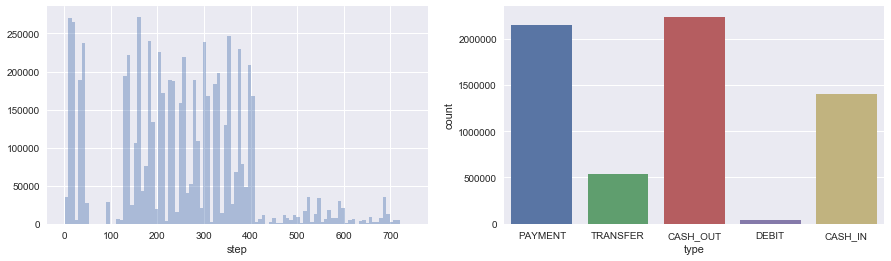

In [18]:
# plot "step" and "type" attributes
sns.set()
fig, ax =plt.subplots(1,2)
fig.set_figwidth(15)
sns.distplot(ori_dataset['step'], kde=False, bins=100, ax=ax[0])
sns.countplot(x=ori_dataset['type'], ax=ax[1])

In [19]:
# let's have a look what "type" do fraudulent transactions possess
ori_dataset[ori_dataset['isFraud'] == 1]['type'].unique()

array([u'TRANSFER', u'CASH_OUT'], dtype=object)

In [20]:
# we select a subset of "type": "transfer" ("cash-out" may be selected for optional excercise)
ori_subset = ori_dataset[ori_dataset['type'] == 'TRANSFER']

In [21]:
# dimension of data
ori_subset.shape

(532909, 11)

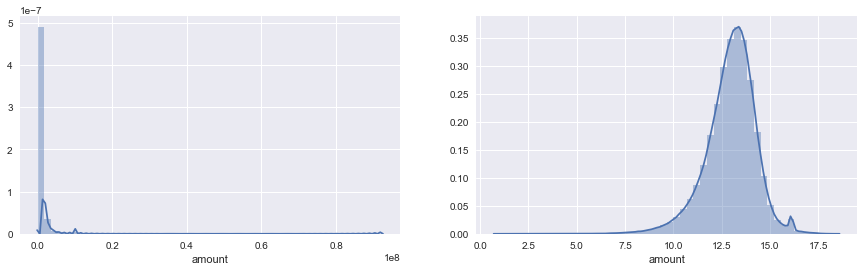

In [22]:
# plot "amount" attribute and its log scale
fig, ax =plt.subplots(1,2)
fig.set_figwidth(15)
sns.distplot(ori_subset['amount'], ax=ax[0])
sns.distplot(ori_subset['amount'].apply(np.log), ax=ax[1])

Preprocess numeric attributes

In [23]:
# select numeric attributes
numeric_attr_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
epsilon = 1e-7

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_subset[numeric_attr_names] + epsilon
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attribute to the range [0,1]
numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

# append 'isFraud' attribute
numeric_attr['isFraud'] = ori_subset['isFraud']

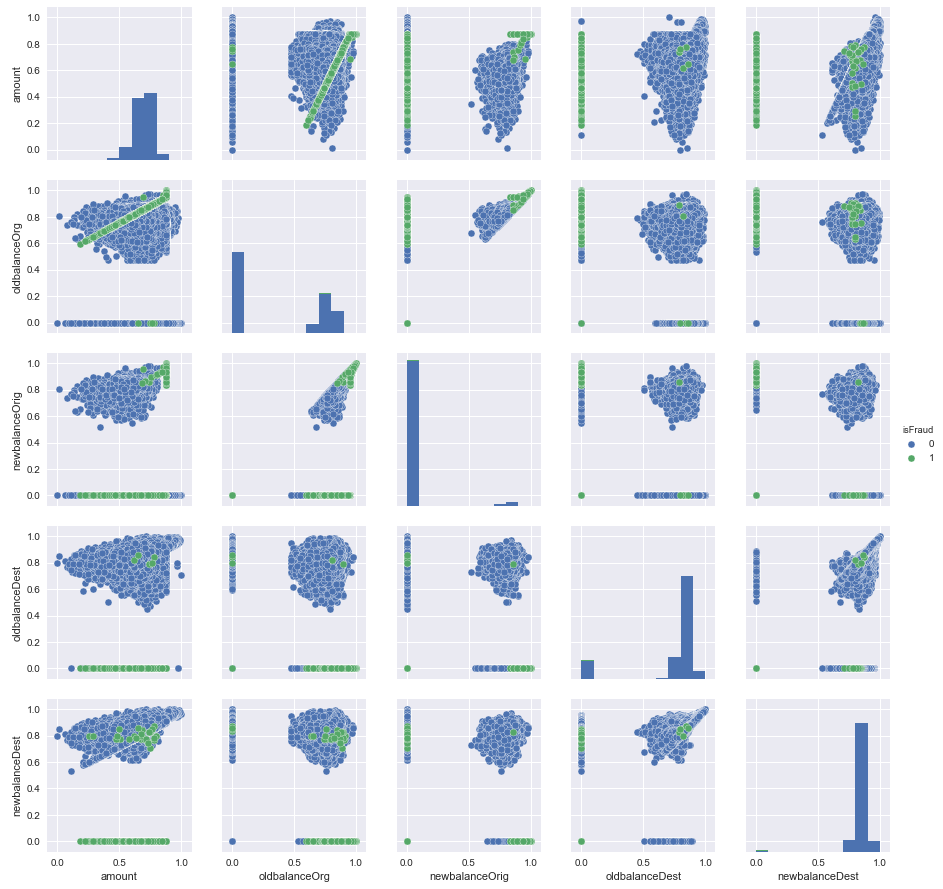

In [24]:
# plot numeric attributes scaled under natural log
if os.path.exists('./images/numeric_attr_pair_plot.png'):
    display(Image('./images/numeric_attr_pair_plot.png'))
else:
    sns.pairplot(data=numeric_attr, vars=numeric_attr_names, hue='isFraud')

In [25]:
# number of distinct values possessed by 'nameOrig'
ori_subset['nameOrig'].nunique()

532839

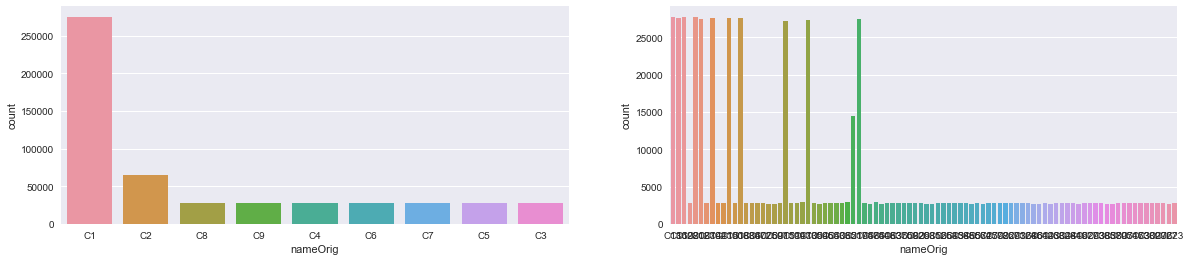

In [26]:
# if we select first 2 or 3 characters
nameOrig_slice_2 = ori_subset['nameOrig'].str.slice(0, 2)
nameOrig_slice_3 = ori_subset['nameOrig'].str.slice(0, 3)

nameDest_slice_2 = ori_subset['nameDest'].str.slice(0, 2)
nameDest_slice_3 = ori_subset['nameDest'].str.slice(0, 3)

fig, ax =plt.subplots(1,2)
fig.set_figwidth(20)
sns.countplot(x=nameOrig_slice_2, ax=ax[0])
sns.countplot(x=nameOrig_slice_3, ax=ax[1])
# g.set_xticklabels(rotation=90)

In [27]:
# select categorical attributes
ori_subset_categ = pd.concat([ori_subset['type'], nameOrig_slice_3, nameDest_slice_3], 
                             axis = 1,
                             names = ['type', 'nameOrig', 'nameDest'])
# select numeric attributes
ori_subset_numeric = numeric_attr.drop('isFraud', axis=1)

### 4.x "One-Hot" Encoded Feature Representation

<img align="middle" style="max-width: 450px; height: auto" src="images/encoding.png">

In [28]:
# transform categorcal attributes into a sparse representation uning one-hot transformation
ori_subset_categ_transformed = pd.get_dummies(ori_subset_categ)

In [29]:
# join categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_subset_categ_transformed, ori_subset_numeric],
                                   axis = 1)
ori_subset_transformed.shape

(532909, 186)

In [30]:
# prepate the dataset for pytorch loader
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

## 5. Training the Autoencoder Neural Network (AAEN) Model

We have specified the AENN model and preprocessed the dataset, let's now start to train our model. Therefore, we define the number of training epochs as 10 with a mini-batch size of 128. This means that the whole dataset will be fed to the AENN 10 times in chunks of 128 transactions.

In [41]:
# specify training parameters
num_epochs = 20
mini_batch_size = 128

During the training phase, we will fetch the mini-batches one by one from the entire population of financial transactions. We will use PyTorchs `DataLoader` that provides single- or multi-process iterators over a given dataset to load one mini-batches at a time. By enabling `shuffle=True` the data will be reshuffled at every epoch. 

In [32]:
#convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retreive deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

Finally, we start start to train the model. The training procedure of each minibatch is performed as follows: 

>1. do a forward pass through the encoder-decoder part, 
>2. compute the binary-cross-entropy reconstruction loss $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i})$, 
>3. do a backward pass through the encoder-decoder part, and 
>4. update the parameteres of the encoder $f_\theta(\cdot)$ and decoder $g_\theta(\cdot)$ networks.

When training our AENN model it is useful to monitor whether the loss decreases with progressing training. Therefore, we evaluate the reconstruction performance of the entire dataset after each training epoch `loss_function(reconstruction, data)`. Based on this evaluation we can conclude on how the training progresses and whether the loss is converging and therfore the model is not improving any further.

Furthermore, after each training epoch want to save a checkpoints of the trained models, both the `encoder` and `decoder` model. You might to come back to them and use it in another program, compare it to other models or do any other kind of evaluation. Moreover, you probably want to save checkpoints at regular intervals during training so in case your computer crashes during training you can continue from the last checkpoint rather than start over from scratch.

This is achieved using the PyTorch's `torch.save` function which allows for saving models to a disk file. The saved models contain the network design and trained model parameter values.

In [42]:
# init collection of mini-batch losses
losses = []

# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# train autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()

    # iterate over all mini-batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data
        
        # =================== compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)
        
        # =================== backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()
        
        # =================== update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== log ==============================

        # log training status each 100 mini batches
        if mini_batch_count % 1000 == 0:

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}'.format(now, (epoch+1), num_epochs, mini_batch_count))
    
    # set networks in training mode (don't apply dropout)
    encoder_train.eval()
    decoder_train.eval()

    # reconstruct encoded transactional data
    reconstruction = decoder_train(encoder_train(data))
    
    # determine reconstruction loss - all transactions
    reconstruction_loss_all = loss_function(reconstruction, data)
            
    # collect reconstruction loss
    losses.extend([reconstruction_loss.data[0]])
    
    # print reconstuction loss results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss.data[0]))
                    
    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))

[LOG 20180219-07:47:45] training status, epoch: [0001/0020], batch: 1000
[LOG 20180219-07:47:52] training status, epoch: [0001/0020], batch: 2000
[LOG 20180219-07:47:59] training status, epoch: [0001/0020], batch: 3000
[LOG 20180219-07:48:07] training status, epoch: [0001/0020], batch: 4000
[LOG 20180219-07:48:19] training status, epoch: [0001/0020], loss: 0.0249255598
[LOG 20180219-07:48:26] training status, epoch: [0002/0020], batch: 1000
[LOG 20180219-07:48:33] training status, epoch: [0002/0020], batch: 2000
[LOG 20180219-07:48:40] training status, epoch: [0002/0020], batch: 3000
[LOG 20180219-07:48:47] training status, epoch: [0002/0020], batch: 4000
[LOG 20180219-07:48:59] training status, epoch: [0002/0020], loss: 0.0222867783
[LOG 20180219-07:49:06] training status, epoch: [0003/0020], batch: 1000
[LOG 20180219-07:49:13] training status, epoch: [0003/0020], batch: 2000
[LOG 20180219-07:49:19] training status, epoch: [0003/0020], batch: 3000
[LOG 20180219-07:49:26] training stat

The first thing that we usually check when training an AENN model is whether the loss function is going down. How does the loss of learning change as we train our model? After 5 epochs we can clearly see our training loss  significantly went down which means our network did a pretty good job in learning. The reconstruction error on our training and test data seems to converge nicely. 

Let’s now visualize the loss history and see how the training progressed.

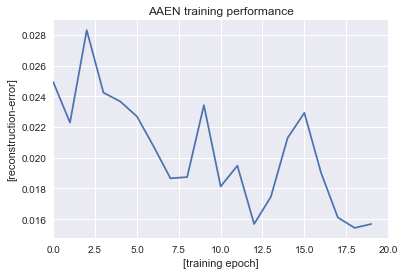

In [43]:
# plot the training progress
plt.plot(range(0, len(losses)), losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(losses)])
plt.ylabel('[reconstruction-error]')
#plt.ylim([0.0, 1.0])
plt.title('AAEN training performance')

From the plot of accuracy we can see that the model could probably be trained a few more epochs as the trend for the reconstruction loss is still decreasing for the last few epochs. We can also observer that the model has not yet over-learned the financial transactions, showing still a certain degree of reconstruction error.

In order to save time, we will continue the lab in the following section of the notebook using a model that was already pretrained by 100 epochs. 

## 6. Evaluating the Autoencoder Neural Network (AAEN) Model

Now that the neural network is trained, we can use it to make an anomaly assessment of the entire financial transactions in the training data. To do that, you can reuse the same construction phase, but change the execution phase like this: First the code loads the model parameters from disk.

In [ ]:
# specify trained models to be loaded
encoder_model_name = "20180215-14_09_36_ep_10_encoder_model.pth"
decoder_model_name = "20180215-14_09_36_ep_10_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()e

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

In [ ]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in training mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

In [ ]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = loss_function(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.data[0]))

In [ ]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).data[0]

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individial reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

In [ ]:
# prepare reconstruction error plot
fig = plt.figure()
ax = fig.add_subplot(111)

plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

regular_data = plot_data[ori_subset.isFraud == 0]
fraud_data = plot_data[ori_subset.isFraud == 1]

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o") # plot regular transactions
ax.scatter(fraud_data[:, 0], fraud_data[:, 1], c='C1', marker="^") # plot fraudulent transactions

## 7. Optional Excercises

Please read ahead and only come back to these optional exercises if time permits.

**1. Train from scratch** [15 mins]

First, change the # of epochs to 10 in the above cell. Second, put the starting learning rate back to **0.001**. Third, comment out the two line where the pre-trained model is loaded (under "Restore latest checkpoint"). Then re-run everything using Kernel -> Restart & Run All. 

**2. What would happen if we remove one of the fully-connected layers?** [15 mins]

We designed a specific model for the lab because experiments show that the structure depicted in Figure 4 provided the best accuracy. Let's see what kind of correlation we would get if remove one of the LSTM cells. First, follow all the instructions for training from scratch if you haven't already. Then open the [dnn.py](../edit/dnn.py) and replace the number "2" in line 8 with "1". 

File->Save for dnn.py 

Re-run the whole notebook using Kernel->Restart & Run All menu.

## 8. Lab Summary

ToDo - Timur and Marco

## 9. Post-Lab Excercises

We recommend you to try the following steps after the lab:

1. Try to implement shallow and deeper autoencoder architectures (by removing and adding an arbitrary number of fully-connected layers). Analyze the performance in terms of training time and reconstruction error.

2. Try using other dimensionality reduction techniques such as principal component analysis, non-negative matrix factorization or sparse coding and compare the detected anomalies with the ones detected by the autoencoder.

3. Try using other autoencoder architectures such as denoising or adversarial autoencoder and compare the results with the vanilla autoencoder architecture implemented above.

## XX. References

[1] ACFE, Report to the Nations on Occupational Fraud and Abuse, The 2016 Global Fraud Study, Association of Certified Fraud Examiners (ACFE), 2016.

[2] J. T. Wells, Corporate Fraud Handbook: Prevention and Detection, John Wiley & Sons, 2017.

[3] PwC, Adjusting the Lens on Economic Crime, The Global Economic Crime Survey 2016, PricewaterhouseCoopers LLP, 2016.

[4] S. Markovitch, P. Willmott, Accelerating the digitization of business processes, McKinsey & Company (2014) 1–5.

[5] SAP, SAP Global Corporate Affairs, Corporate Factsheet 2017, 2017.

[6] X. Glorot and Y. Bengio. Understanding the difficulty of training deep feedforward neural networks. Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[7] B. Xu, N. Wang, T. Chen, and M. Li. Empirical Evaluation of Rectified Activations in Convolution Network. ICML Deep Learning Workshop, pages 1–5, 2015.

[8] D. P. Kingma and J. Ba. Adam: A Method for Stochastic Optimization. arXiv preprint, pages 1–15, 2014. URL: http://arxiv.org/abs/1412.6980.

[9] G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever, R. R. Salakhutdinov, Improving neural networks by preventing co-adaptation of feature detectors, Technical Report, 2012.

In [ ]:
[]